In [1]:
import os
import numpy as np
import torch
import pyedflib
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn as nn
import torch.nn.functional as F
from scipy.fft import fft
from collections import Counter

# 설정
sampling_rate = 256
segment_length = 30 * sampling_rate
fft_length = segment_length // 2
label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 1,
    'Sleep stage N3': 2,
    'Sleep stage R': 3
}
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"

In [2]:
def segment_and_fft(signal):
    segments = []
    for start in range(0, len(signal) - segment_length, segment_length):
        segment = signal[start:start+segment_length]
        fft_vals = np.abs(fft(segment))[:fft_length]
        segments.append(fft_vals)
    return np.array(segments)


In [3]:
def load_data_from_sn(sn_list):
    all_segments = []
    all_labels = []
    for sn in sn_list:
        base = f"SN{sn:03d}"
        ecg_path = os.path.join(root_dir, f"{base}.edf")
        label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")
        if not os.path.exists(ecg_path) or not os.path.exists(label_path):
            print(f"❌ 파일 없음: {base}")
            continue
        try:
            ecg_reader = pyedflib.EdfReader(ecg_path)
            ecg_signal = ecg_reader.readSignal(7)
        finally:
            ecg_reader._close()
        try:
            label_reader = pyedflib.EdfReader(label_path)
            annotations = label_reader.readAnnotations()
        finally:
            label_reader._close()
        onsets, durations, labels = annotations
        label_seq = []
        for i in range(len(labels)):
            label_str = labels[i].decode() if isinstance(labels[i], bytes) else labels[i]
            if label_str in label_map:
                label_index = label_map[label_str]
                num_segments = int(durations[i] // 30)
                label_seq.extend([label_index] * num_segments)
        fft_segments = segment_and_fft(ecg_signal)
        max_segments = len(fft_segments)
        usable_len = min(len(label_seq), max_segments)
        all_segments.extend(fft_segments[:usable_len])
        all_labels.extend(label_seq[:usable_len])
    X = torch.tensor(np.expand_dims(np.array(all_segments), axis=1), dtype=torch.float32)
    y = torch.tensor(all_labels, dtype=torch.long)
    return X, y

In [4]:
def load_balanced_data_from_sn(sn_list):
    all_segments = []
    all_labels = []
    for sn in sn_list:
        try:
            X, y = load_data_from_sn([sn])
        except Exception as e:
            print(f"❌ SN{sn:03d} 불러오기 실패: {e}")
            continue
        if len(y) == 0:
            print(f"⚠️ SN{sn:03d}: 라벨 없음 → 건너뜀")
            continue
        y_np = y.numpy()
        X_np = X.numpy()
        label_counts = Counter(y_np)
        if len(label_counts) < 2:
            print(f"⚠️ SN{sn:03d}: 라벨 다양성 부족 → 건너뜀")
            continue
        min_count = min(label_counts.values())
        indices = []
        for label in sorted(label_counts.keys()):
            label_indices = np.where(y_np == label)[0]
            if len(label_indices) < min_count:
                continue
            sampled = np.random.choice(label_indices, min_count, replace=False)
            indices.extend(sampled)
        if not indices:
            print(f"⚠️ SN{sn:03d}: 유효한 샘플 없음 → 건너뜀")
            continue
        np.random.shuffle(indices)
        all_segments.append(X_np[indices])
        all_labels.append(y_np[indices])
        print(f"✅ SN{sn:03d} 처리 완료: 클래스당 {min_count}개")
    if not all_segments:
        raise ValueError("⚠️ 유효한 데이터가 없습니다. SN 목록을 다시 확인하세요.")
    X_all = torch.tensor(np.concatenate(all_segments), dtype=torch.float32)
    y_all = torch.tensor(np.concatenate(all_labels), dtype=torch.long)
    return X_all, y_all

In [5]:
X_train, y_train = load_balanced_data_from_sn(list(range(1, 94)))
X_val, y_val = load_balanced_data_from_sn(list(range(94, 124)))
X_test, y_test = load_data_from_sn(list(range(124, 154)))

✅ SN001 처리 완료: 클래스당 23개


✅ SN002 처리 완료: 클래스당 82개


✅ SN003 처리 완료: 클래스당 150개


✅ SN004 처리 완료: 클래스당 64개


✅ SN005 처리 완료: 클래스당 127개


✅ SN006 처리 완료: 클래스당 65개


✅ SN007 처리 완료: 클래스당 67개


✅ SN008 처리 완료: 클래스당 39개


✅ SN009 처리 완료: 클래스당 91개


✅ SN010 처리 완료: 클래스당 101개


✅ SN011 처리 완료: 클래스당 37개


✅ SN012 처리 완료: 클래스당 184개


✅ SN013 처리 완료: 클래스당 65개
❌ 파일 없음: SN014
⚠️ SN014: 라벨 없음 → 건너뜀


✅ SN015 처리 완료: 클래스당 102개


✅ SN016 처리 완료: 클래스당 24개
✅ SN017 처리 완료: 클래스당 96개


✅ SN018 처리 완료: 클래스당 19개


✅ SN019 처리 완료: 클래스당 72개


✅ SN020 처리 완료: 클래스당 67개


✅ SN021 처리 완료: 클래스당 156개


✅ SN022 처리 완료: 클래스당 115개


✅ SN023 처리 완료: 클래스당 74개


✅ SN024 처리 완료: 클래스당 70개


✅ SN025 처리 완료: 클래스당 106개


✅ SN026 처리 완료: 클래스당 127개


✅ SN027 처리 완료: 클래스당 19개


✅ SN028 처리 완료: 클래스당 136개


✅ SN029 처리 완료: 클래스당 59개


✅ SN030 처리 완료: 클래스당 108개


✅ SN031 처리 완료: 클래스당 74개


✅ SN032 처리 완료: 클래스당 133개


✅ SN033 처리 완료: 클래스당 47개


✅ SN034 처리 완료: 클래스당 75개


✅ SN035 처리 완료: 클래스당 108개


✅ SN036 처리 완료: 클래스당 87개


✅ SN037 처리 완료: 클래스당 65개


✅ SN038 처리 완료: 클래스당 61개


✅ SN039 처리 완료: 클래스당 108개


✅ SN040 처리 완료: 클래스당 62개


✅ SN041 처리 완료: 클래스당 130개


✅ SN042 처리 완료: 클래스당 148개


✅ SN043 처리 완료: 클래스당 56개


✅ SN044 처리 완료: 클래스당 55개


✅ SN045 처리 완료: 클래스당 129개


✅ SN046 처리 완료: 클래스당 49개


✅ SN047 처리 완료: 클래스당 125개


✅ SN048 처리 완료: 클래스당 146개


✅ SN049 처리 완료: 클래스당 41개


✅ SN050 처리 완료: 클래스당 25개


✅ SN051 처리 완료: 클래스당 84개


✅ SN052 처리 완료: 클래스당 59개


✅ SN053 처리 완료: 클래스당 163개


✅ SN054 처리 완료: 클래스당 28개


✅ SN055 처리 완료: 클래스당 115개


✅ SN056 처리 완료: 클래스당 64개
✅ SN057 처리 완료: 클래스당 7개


✅ SN058 처리 완료: 클래스당 103개


✅ SN059 처리 완료: 클래스당 138개


✅ SN060 처리 완료: 클래스당 46개


✅ SN061 처리 완료: 클래스당 150개


✅ SN062 처리 완료: 클래스당 5개


✅ SN063 처리 완료: 클래스당 139개
❌ 파일 없음: SN064
⚠️ SN064: 라벨 없음 → 건너뜀


✅ SN065 처리 완료: 클래스당 65개


✅ SN066 처리 완료: 클래스당 88개


✅ SN067 처리 완료: 클래스당 123개


✅ SN068 처리 완료: 클래스당 116개


✅ SN069 처리 완료: 클래스당 69개
✅ SN070 처리 완료: 클래스당 35개


✅ SN071 처리 완료: 클래스당 16개


✅ SN072 처리 완료: 클래스당 115개


✅ SN073 처리 완료: 클래스당 39개


✅ SN074 처리 완료: 클래스당 37개


✅ SN075 처리 완료: 클래스당 186개


✅ SN076 처리 완료: 클래스당 56개


✅ SN077 처리 완료: 클래스당 85개


✅ SN078 처리 완료: 클래스당 55개


✅ SN079 처리 완료: 클래스당 61개


✅ SN080 처리 완료: 클래스당 28개


✅ SN081 처리 완료: 클래스당 2개


✅ SN082 처리 완료: 클래스당 37개


✅ SN083 처리 완료: 클래스당 136개


✅ SN084 처리 완료: 클래스당 27개


✅ SN085 처리 완료: 클래스당 111개


✅ SN086 처리 완료: 클래스당 110개


✅ SN087 처리 완료: 클래스당 34개
✅ SN088 처리 완료: 클래스당 125개


✅ SN089 처리 완료: 클래스당 85개


✅ SN090 처리 완료: 클래스당 76개


✅ SN091 처리 완료: 클래스당 40개


✅ SN092 처리 완료: 클래스당 93개


✅ SN093 처리 완료: 클래스당 71개


✅ SN094 처리 완료: 클래스당 79개


✅ SN095 처리 완료: 클래스당 50개


✅ SN096 처리 완료: 클래스당 55개


✅ SN097 처리 완료: 클래스당 46개


✅ SN098 처리 완료: 클래스당 80개


✅ SN099 처리 완료: 클래스당 56개


✅ SN100 처리 완료: 클래스당 81개


✅ SN101 처리 완료: 클래스당 120개


✅ SN102 처리 완료: 클래스당 36개


✅ SN103 처리 완료: 클래스당 70개


✅ SN104 처리 완료: 클래스당 104개


✅ SN105 처리 완료: 클래스당 34개


✅ SN106 처리 완료: 클래스당 53개


✅ SN107 처리 완료: 클래스당 77개


✅ SN108 처리 완료: 클래스당 50개


✅ SN109 처리 완료: 클래스당 48개


✅ SN110 처리 완료: 클래스당 96개


✅ SN111 처리 완료: 클래스당 135개


✅ SN112 처리 완료: 클래스당 83개


✅ SN113 처리 완료: 클래스당 85개


✅ SN114 처리 완료: 클래스당 73개


✅ SN115 처리 완료: 클래스당 98개


✅ SN116 처리 완료: 클래스당 43개


✅ SN117 처리 완료: 클래스당 108개


✅ SN118 처리 완료: 클래스당 114개


✅ SN119 처리 완료: 클래스당 89개


✅ SN120 처리 완료: 클래스당 29개


✅ SN121 처리 완료: 클래스당 61개


✅ SN122 처리 완료: 클래스당 66개


✅ SN123 처리 완료: 클래스당 98개


❌ 파일 없음: SN135


In [6]:
class ECGSleepCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(ECGSleepCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (fft_length // 8), 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [7]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGSleepCNN(num_classes=4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

for epoch in range(50):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        loss = criterion(outputs, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        _, pred = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()
    train_acc = 100 * correct / total
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            val_total += yb.size(0)
            val_correct += (pred == yb).sum().item()
    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    print(f"📘 Epoch {epoch+1} | Train Loss: {loss_sum:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")



📘 Epoch 1 | Train Loss: 1196.3704 | Train Acc: 36.93% | Val Loss: 1.9417 | Val Acc: 25.26%


📘 Epoch 2 | Train Loss: 1152.2084 | Train Acc: 40.82% | Val Loss: 2.0390 | Val Acc: 25.08%


📘 Epoch 3 | Train Loss: 1122.0509 | Train Acc: 43.72% | Val Loss: 2.1535 | Val Acc: 24.94%


📘 Epoch 4 | Train Loss: 1098.0759 | Train Acc: 45.85% | Val Loss: 1.9170 | Val Acc: 24.91%


📘 Epoch 5 | Train Loss: 1076.4485 | Train Acc: 47.90% | Val Loss: 1.9417 | Val Acc: 25.73%


📘 Epoch 6 | Train Loss: 1051.9801 | Train Acc: 49.57% | Val Loss: 2.0989 | Val Acc: 25.71%


📘 Epoch 7 | Train Loss: 1027.3223 | Train Acc: 50.92% | Val Loss: 1.7875 | Val Acc: 25.85%


📘 Epoch 8 | Train Loss: 1004.9669 | Train Acc: 52.80% | Val Loss: 1.9136 | Val Acc: 26.27%


📘 Epoch 9 | Train Loss: 985.4792 | Train Acc: 53.97% | Val Loss: 1.8403 | Val Acc: 26.28%


📘 Epoch 10 | Train Loss: 963.4637 | Train Acc: 55.72% | Val Loss: 1.7865 | Val Acc: 26.12%


📘 Epoch 11 | Train Loss: 946.8890 | Train Acc: 57.05% | Val Loss: 1.8272 | Val Acc: 27.34%


📘 Epoch 12 | Train Loss: 924.5166 | Train Acc: 57.97% | Val Loss: 1.7093 | Val Acc: 27.89%


📘 Epoch 13 | Train Loss: 902.5895 | Train Acc: 59.55% | Val Loss: 1.7787 | Val Acc: 30.28%


📘 Epoch 14 | Train Loss: 883.1284 | Train Acc: 60.65% | Val Loss: 1.6915 | Val Acc: 29.27%


📘 Epoch 15 | Train Loss: 861.4516 | Train Acc: 62.14% | Val Loss: 1.7459 | Val Acc: 29.23%


📘 Epoch 16 | Train Loss: 841.3695 | Train Acc: 63.28% | Val Loss: 1.7029 | Val Acc: 31.19%


📘 Epoch 17 | Train Loss: 822.4477 | Train Acc: 64.53% | Val Loss: 1.9873 | Val Acc: 30.28%


📘 Epoch 18 | Train Loss: 801.4923 | Train Acc: 65.75% | Val Loss: 1.7927 | Val Acc: 31.02%


📘 Epoch 19 | Train Loss: 784.3157 | Train Acc: 66.68% | Val Loss: 1.7094 | Val Acc: 32.04%


📘 Epoch 20 | Train Loss: 766.4939 | Train Acc: 67.79% | Val Loss: 1.8548 | Val Acc: 31.69%


📘 Epoch 21 | Train Loss: 744.3259 | Train Acc: 68.82% | Val Loss: 1.8060 | Val Acc: 31.75%


📘 Epoch 22 | Train Loss: 725.3208 | Train Acc: 69.91% | Val Loss: 2.0185 | Val Acc: 30.86%


📘 Epoch 23 | Train Loss: 706.5031 | Train Acc: 70.83% | Val Loss: 2.0025 | Val Acc: 32.16%


📘 Epoch 24 | Train Loss: 690.4330 | Train Acc: 71.81% | Val Loss: 1.7384 | Val Acc: 31.02%


📘 Epoch 25 | Train Loss: 672.6757 | Train Acc: 72.87% | Val Loss: 1.7551 | Val Acc: 32.56%


📘 Epoch 26 | Train Loss: 647.1421 | Train Acc: 74.20% | Val Loss: 1.8112 | Val Acc: 32.03%


📘 Epoch 27 | Train Loss: 634.5938 | Train Acc: 74.99% | Val Loss: 2.0930 | Val Acc: 31.93%


📘 Epoch 28 | Train Loss: 614.4621 | Train Acc: 76.01% | Val Loss: 2.3824 | Val Acc: 32.07%


📘 Epoch 29 | Train Loss: 596.3105 | Train Acc: 76.84% | Val Loss: 2.0953 | Val Acc: 30.54%


📘 Epoch 30 | Train Loss: 575.8184 | Train Acc: 77.62% | Val Loss: 2.2035 | Val Acc: 31.27%


📘 Epoch 31 | Train Loss: 561.4984 | Train Acc: 78.54% | Val Loss: 2.0425 | Val Acc: 29.90%


📘 Epoch 32 | Train Loss: 541.0703 | Train Acc: 79.67% | Val Loss: 2.2798 | Val Acc: 31.47%


📘 Epoch 33 | Train Loss: 527.4784 | Train Acc: 80.06% | Val Loss: 1.8996 | Val Acc: 30.13%


📘 Epoch 34 | Train Loss: 506.5209 | Train Acc: 81.40% | Val Loss: 1.9843 | Val Acc: 31.95%


📘 Epoch 35 | Train Loss: 495.1898 | Train Acc: 81.85% | Val Loss: 2.1307 | Val Acc: 30.63%


📘 Epoch 36 | Train Loss: 476.8691 | Train Acc: 82.73% | Val Loss: 2.5319 | Val Acc: 31.16%


📘 Epoch 37 | Train Loss: 460.5999 | Train Acc: 83.26% | Val Loss: 2.6594 | Val Acc: 31.43%


📘 Epoch 38 | Train Loss: 445.9510 | Train Acc: 84.13% | Val Loss: 1.8721 | Val Acc: 30.47%


📘 Epoch 39 | Train Loss: 427.6007 | Train Acc: 85.07% | Val Loss: 2.1104 | Val Acc: 31.05%


📘 Epoch 40 | Train Loss: 415.0554 | Train Acc: 85.59% | Val Loss: 2.4153 | Val Acc: 31.80%


📘 Epoch 41 | Train Loss: 398.2850 | Train Acc: 86.35% | Val Loss: 1.9285 | Val Acc: 32.04%


📘 Epoch 42 | Train Loss: 388.0528 | Train Acc: 86.67% | Val Loss: 2.0917 | Val Acc: 31.66%


📘 Epoch 43 | Train Loss: 371.0236 | Train Acc: 87.50% | Val Loss: 2.2454 | Val Acc: 31.19%


📘 Epoch 44 | Train Loss: 358.7192 | Train Acc: 87.95% | Val Loss: 2.3732 | Val Acc: 30.98%


📘 Epoch 45 | Train Loss: 343.8328 | Train Acc: 88.99% | Val Loss: 2.3669 | Val Acc: 29.91%


📘 Epoch 46 | Train Loss: 333.5923 | Train Acc: 89.13% | Val Loss: 2.3473 | Val Acc: 30.44%


📘 Epoch 47 | Train Loss: 318.3560 | Train Acc: 89.86% | Val Loss: 2.4547 | Val Acc: 32.08%


📘 Epoch 48 | Train Loss: 305.9540 | Train Acc: 90.38% | Val Loss: 2.6344 | Val Acc: 30.63%


📘 Epoch 49 | Train Loss: 293.1806 | Train Acc: 90.86% | Val Loss: 2.6073 | Val Acc: 30.71%


📘 Epoch 50 | Train Loss: 282.3309 | Train Acc: 91.35% | Val Loss: 2.7207 | Val Acc: 31.35%


In [8]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for i in range(0, len(X_test), 32):
        xb = X_test[i:i+32].to(device)
        yb = y_test[i:i+32].to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


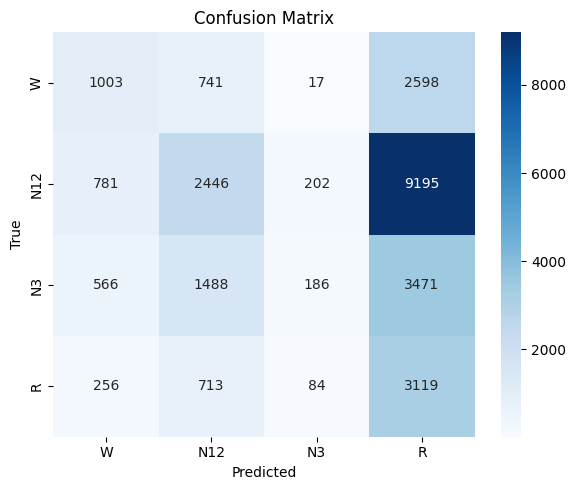

📄 Classification Report:
              precision    recall  f1-score   support

           W       0.38      0.23      0.29      4359
         N12       0.45      0.19      0.27     12624
          N3       0.38      0.03      0.06      5711
           R       0.17      0.75      0.28      4172

    accuracy                           0.25     26866
   macro avg       0.35      0.30      0.22     26866
weighted avg       0.38      0.25      0.23     26866



In [9]:
labels = ['W', 'N12', 'N3', 'R']
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
print("📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))
